## Sliding SIR Modelling for Different Countries

This notebook contains the code to estimate effective reproduction index Rt for different countries, based on COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University, which is available [here][CountryData].

[CountryData]: https://github.com/CSSEGISandData/COVID-19

### Initial setup

Let's start by installing all required libraries...

In [2]:
import sys
!{sys.executable} -m pip install --user --quiet pandas>=1.0.3 matplotlib scipy numpy


In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

### Loading data for all countries

Data is loaded directly from [GitHub Repo][CountryData]. Since the repository is updated regularly with new actual data, we can obtain up-to-data estimations each time we run the code. For your convenience, the data files that we have used in this study are also stored in the `data` directory, so they can be loaded from there, should the current data become unavailable.

In [2]:
infected_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
deaths_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
countries_dataset_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"

In [3]:
countries = pd.read_csv(countries_dataset_url)
infected_original = pd.read_csv(infected_dataset_url)
recovered_original = pd.read_csv(recovered_dataset_url)
deaths_original = pd.read_csv(deaths_dataset_url)
countries.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.0,NaN,NaN,NaN,Afghanistan,33.93911,67.709953,Afghanistan,38928341.0
1,8,AL,ALB,8.0,NaN,NaN,NaN,Albania,41.15330,20.168300,Albania,2877800.0
2,12,DZ,DZA,12.0,NaN,NaN,NaN,Algeria,28.03390,1.659600,Algeria,43851043.0
3,20,AD,AND,20.0,NaN,NaN,NaN,Andorra,42.50630,1.521800,Andorra,77265.0
4,24,AO,AGO,24.0,NaN,NaN,NaN,Angola,-11.20270,17.873900,Angola,32866268.0


Data on infected/recovered cases is located in three separate tables, and we also need the information about country population, which is located in a separate table. Since some countries are further broken down by territories (eg. US - by State/City), we also add those territories together (using `sum`) to get the overall numbers for the country:

In [4]:
population = countries[countries['Province_State'].isnull()][['Country_Region','Population']].rename(columns={'Country_Region' : 'Country/Region'}).set_index('Country/Region')
infected = infected_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
deaths = deaths_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
recovered = recovered_original.groupby('Country/Region').sum().reset_index().set_index('Country/Region').join(population,on='Country/Region')
infected.head()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,Population
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,...,20342,20917,21459,22142,22890,23546,24102,24766,25527,38928341.0
Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,...,1246,1263,1299,1341,1385,1416,1464,1521,1590,2877800.0
Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,...,10154,10265,10382,10484,10589,10698,10810,10919,11031,43851043.0
Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,...,852,852,852,852,852,853,853,853,853,77265.0
Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,...,91,92,96,113,118,130,138,140,142,32866268.0


### Computing Parameters using Sliding SIR model

First, we define the function to solve SIR model with given starting values and parameters

In [7]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Compute SIR model starting from given numbers of infected/removed ppl
def sir_model(infected,removed,N,beta,gamma,ndays):
    t = np.linspace(0,ndays,ndays)
    y0 = N-infected-removed,infected,removed
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    return ret.T # S,I,R

Function `model` computes the model given real values of newly infected people in `V` and removed cases in `R`. It computes SIR model for the given number of days, and then computes and returns loss function between real and computed data.

`fit` then uses SciKit Learn optimization to find the best parameter $\beta$, given fixed $\gamma=$`the_gamma`

In [8]:
# Модель по заданному вектору заболевших V и удалённых R
def model(V,R,N,beta,gamma):
    S,I,R = sir_model(V[0],R[0],N,beta,gamma,len(V))
    dV = np.diff(V)
    dI = np.diff(I+R)
    return np.linalg.norm(dV-dI)

# Fix the gamma parameter
the_gamma = 1/30

# Подобрать параметры модели по векторам V и R
def fit(V,R,N):
    # res = minimize(lambda x:model(V,R,N,x[0],x[1]),x0=[0.5,1/20],method='powell')
    # return res.x[0],res.x[1]
    res = minimize(lambda x:model(V,R,N,x,the_gamma),x0=0.5,method='powell')
    return res.x,the_gamma

## Performing Analysis of a Country

Here we load the data for specified country into separate dataframe (so-called **country dataframe**). `make_frame` re-formats original country data into dataframe and performs running window averaging to smooth curves.

In [9]:
def make_frame(country_name,smooth_window=3):
    f = pd.DataFrame([infected.loc[country_name],recovered.loc[country_name],deaths.loc[country_name]]).T
    population = f.iloc[-1,0]
    f = f.iloc[2:-1].reset_index()
    f.columns = ['Date','Infected','Recovered','Deaths']
    f['Removed'] = f['Recovered']+f['Deaths']
    f["Date"] = pd.to_datetime(f["Date"],format="%m/%d/%y")
    for x in ['Infected','Recovered','Deaths','Removed']:
        f[x+"_Av"] = f[x].rolling(window=smooth_window).mean()
    return population, f

def get_start_index(df):
    return df[df['Infected_Av']>1000].index[0]

`compute_params` is the main method implementing Sliding SIR algorithm: it runs through all days from starting date and performs 7-day fitting of the SIR model using `fit` function above

In [10]:
def compute_params(df,population, start_index, ndays=8):
    for i in range(start_index,len(df)-ndays):
        V = df['Infected_Av'][i:i+ndays].to_numpy()
        R = df['Removed_Av'][i:i+ndays].to_numpy()
        beta,gamma = fit(V,R,population)
        df.loc[i,'Beta'] = beta
        df.loc[i,'Gamma'] = gamma

The method below puts everything together, it takes the country name, loads the data, and performs sliding SIR fitting and Rt calculations. It returns enriched country frame and population.

In [11]:
def analyze(country_name,truncate_frame=True):
    population, df = make_frame(country_name)
    n = get_start_index(df)
    compute_params(df,population,n)
    df['Rt'] = df['Beta'] / df['Gamma']
    return population, df.iloc[n:] if truncate_frame else df

pop, df = analyze('Russia')


In [12]:
df.head()

,Date,Infected,Recovered,Deaths,Removed,Infected_Av,Recovered_Av,Deaths_Av,Removed_Av,Beta,Gamma,Rt
66,2020-03-28,1264.0,49.0,4.0,53.0,1046.666667,44.000000,3.666667,47.666667,0.187094,0.033333,5.612825
67,2020-03-29,1534.0,64.0,8.0,72.0,1278.000000,52.666667,5.333333,58.000000,0.175746,0.033333,5.272391
68,2020-03-30,1836.0,66.0,9.0,75.0,1544.666667,59.666667,7.000000,66.666667,0.168310,0.033333,5.049302
69,2020-03-31,2337.0,121.0,17.0,138.0,1902.333333,83.666667,11.333333,95.000000,0.162722,0.033333,4.881660
70,2020-04-01,2777.0,190.0,24.0,214.0,2316.666667,125.666667,16.666667,142.333333,0.158950,0.033333,4.768512


Below, we display the data for Russia. A couple of specific dates are highlighted as well.

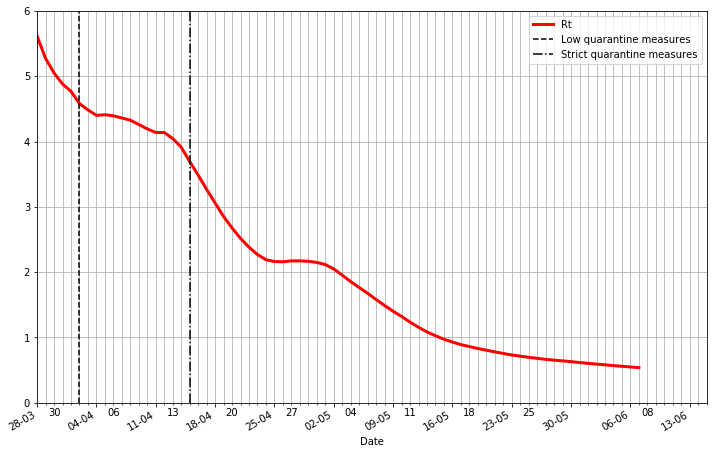

In [13]:
import matplotlib.dates as mdates
ax = df.plot('Date','Rt',linewidth=3,color='red',grid=True,ylim=(0,6),figsize=(12,8))
ax.axvline('2020-04-02', color='k', linestyle='--',label='Low quarantine measures')
ax.axvline('2020-04-15', color='k', linestyle='-.',label='Strict quarantine measures')
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gcf().autofmt_xdate()
plt.legend()

Population = 145934460.0, Infection start date (>100) = 2020-03-28


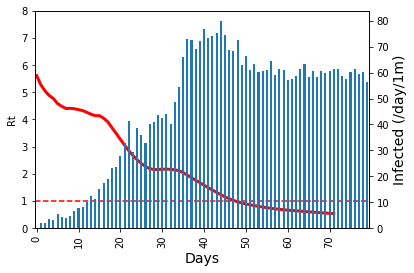

In [14]:
def plot(population,df,ax=None):
    n = 0 # get_start_index(df)
    start_date = df.iloc[n,0]
    if ax is None:
        print("Population = {}, Infection start date (>100) = {}".format(population,start_date.date()))
    df['Days'] = df['Date'].apply(lambda x : (x-start_date).days)
    df['PI'] = df['Infected'] / population * 100
    df['Delta_Infected_Gr'] = (df['Infected'].diff()).clip(lower=0) / population * 1000000
    ax = ax or plt.gca()
    ax = df.plot('Days','Rt',ax=ax,legend=False,linewidth=3,color='red')
    ax.axhline(y = 1,linestyle='--', color='red')
    ax.set_ylim(0,8)
    ax.set_ylabel('Rt')
    df.plot(x='Days',y='Delta_Infected_Gr',secondary_y=True,kind='bar',ax=ax,legend=False)#,xticks=df['Days'][::10])
    ax.set_xlabel('Days',fontsize=14)
    ax.set_xticks(df['Days'][::10])
    ax.set_xticklabels(df['Days'][::10])
    ax.right_ax.set_ylabel('Infected (/day/1m)',fontsize=14)

plot(pop,df)

## Comparing Several Countries

We define several contries as a grid, because it is easier to study them group by group. This grid is also used for plotting.

We run computations for each country, and store its **country frame** into a dictionary.

In [15]:
countries = [
    ['Spain','Italy', 'France', 'Germany'],
    ['Brazil', 'United Kingdom', 'US', 'Russia'],
    ['Sweden', 'Norway', 'Finland', 'Denmark'],        
    ['China', 'Japan', 'Korea, South', 'India']]

# Compute all countries
country_data = {}
for x in sum(countries,[]):
    print("Computing data for {}".format(x))
    country_data[x] = analyze(x)

Computing data for Spain
Computing data for Italy
Computing data for France
Computing data for Germany
Computing data for Brazil
Computing data for United Kingdom
Computing data for US
Computing data for Russia
Computing data for Sweden
Computing data for Norway
Computing data for Finland
Computing data for Denmark
Computing data for China
Computing data for Japan
Computing data for Korea, South
Computing data for India


Producing a table of $R_0$ values for countries. It is as simple as taking the $R_t$ value at the index 0

In [16]:
r0s = pd.DataFrame([ (c,k[1].iloc[0]['Rt']) for c,k in country_data.items() ],columns=['Country','R0'])
r0s

,Country,R0
0,Spain,8.269101
1,Italy,6.389969
2,France,6.331031
3,Germany,7.290338
4,Brazil,4.786171
5,United Kingdom,6.465374
6,US,9.020070
7,Russia,5.612825
8,Sweden,2.632905
9,Norway,2.816183


Now let's produce multi-country plot.

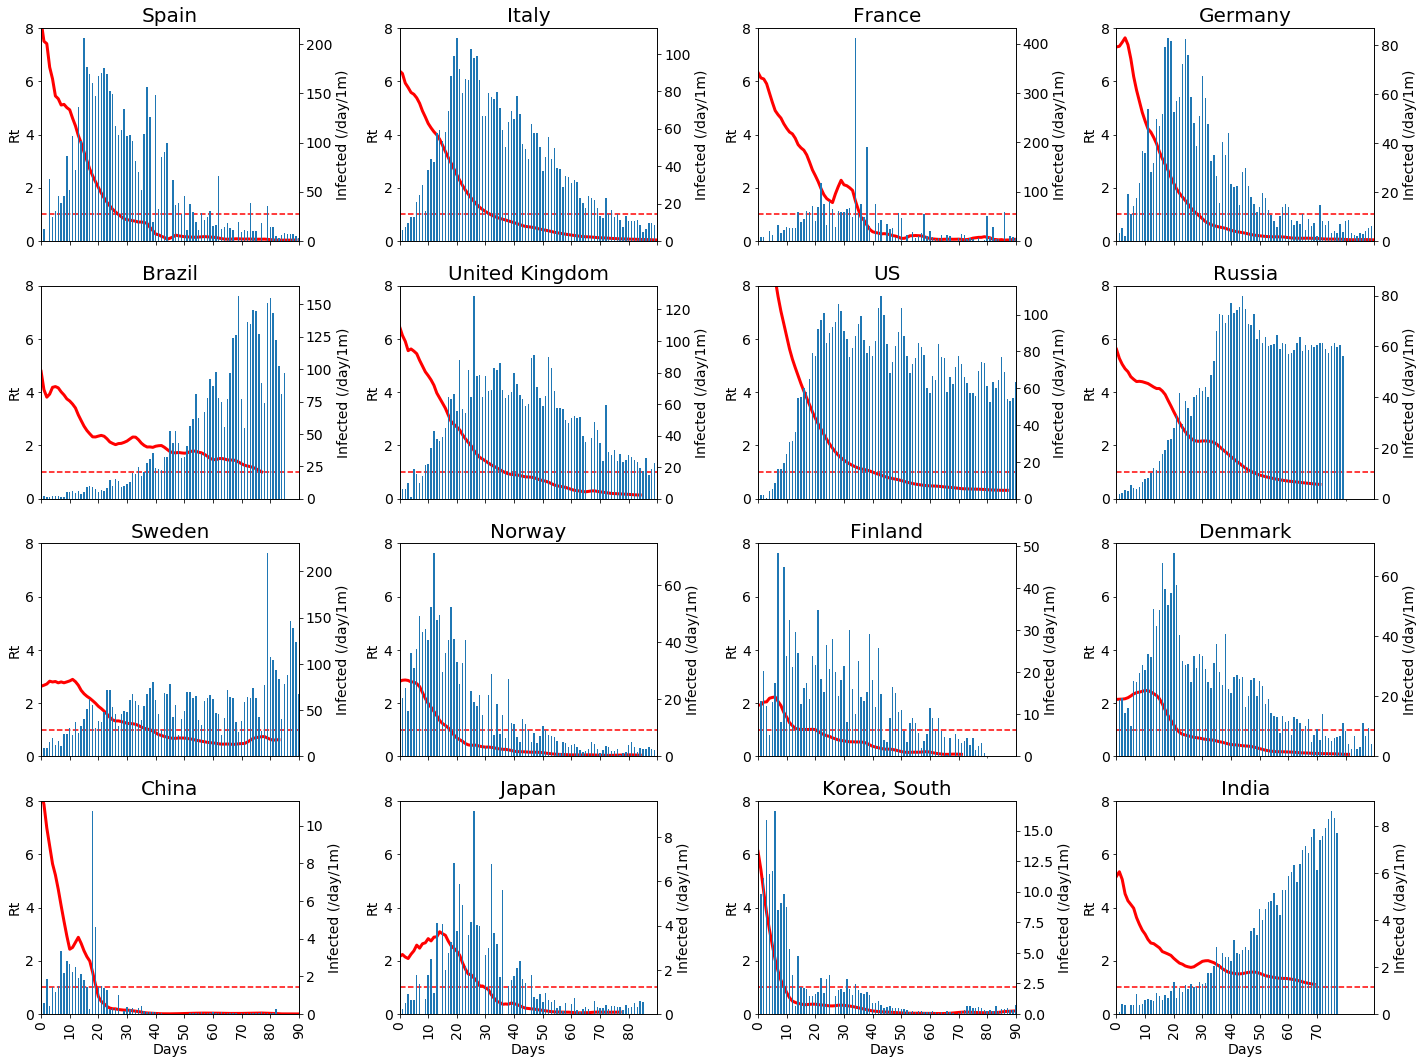

In [17]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
plt.rc('font',size=14)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_data[c]
        plot(pop,df,ax=ax[i,j])
        ax[i,j].set_xlim(0,90)
        ax[i,j].set_title(c,fontsize=20)
        ax[i,j].axes.xaxis.set_visible(True)
fig.tight_layout()
plt.show()

## Comparing $R_t$ Graphs

Now we want to plot the $R_t$ graphs on one plot. To do that, we convert the dictionary to one dataframe, with days as rows, and country names as columns:

In [18]:
rtdf = [
    cd[1][['Days','Rt']].set_index('Days').rename(columns={'Rt':c }) for c,cd in country_data.items()]

In [19]:
from functools import reduce
rtdf = reduce(lambda df,f : df.join(f), rtdf)

In [20]:
rtdf

,Spain,Italy,France,Germany,Brazil,United Kingdom,US,Russia,Sweden,Norway,Finland,Denmark,China,Japan,"Korea, South",India
Days,,,,,,,,,,,,,,,,
0,8.269101,6.389969,6.331031,7.290338,4.786171,6.465374,9.020070,5.612825,2.632905,2.816183,1.925157,2.140022,8.342098,2.158008,6.108928,5.172934
1,7.504460,6.292825,6.128045,7.314705,4.094580,6.134722,9.113000,5.272391,2.672335,2.859783,1.931282,2.147184,7.874408,2.236598,5.427024,5.344839
2,7.412181,5.933487,6.088109,7.463884,3.813978,5.911593,9.094811,5.049302,2.718020,2.868723,2.038539,2.150639,6.986361,2.141059,4.588126,5.055863
3,6.529068,5.767845,5.907078,7.632438,3.929132,5.560491,9.193874,4.881660,2.823583,2.851510,2.048098,2.165207,6.316354,2.084858,3.799116,4.515660
4,6.089457,5.581470,5.558391,7.371976,4.182758,5.624212,9.123930,4.768512,2.795222,2.797135,2.183982,2.203704,5.641770,2.246004,3.158328,4.253861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,NaN,0.037390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002251,NaN,0.101540,NaN
94,NaN,0.037003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001801,NaN,0.103562,NaN
95,NaN,0.037302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001262,NaN,0.108732,NaN


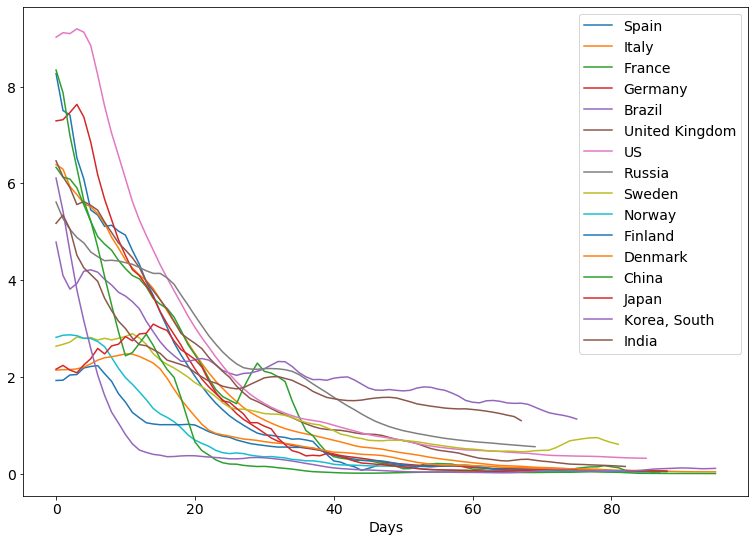

In [74]:
rtdf.plot(figsize=(13,9))

It is impractival to see all graphs on one plot, so we plot only a few countries of interest.

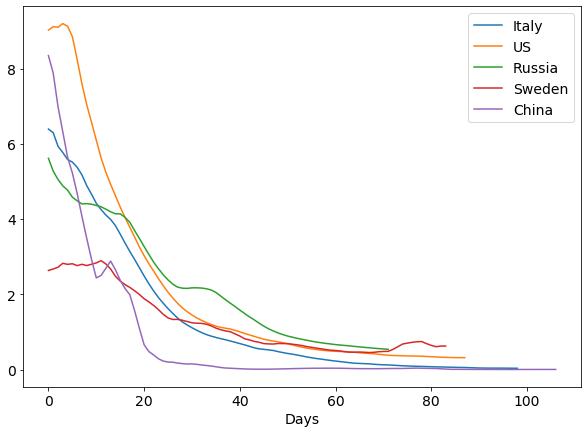

In [21]:
def plot_countries(l):
    rtdf = [cd[1][['Days','Rt']].set_index('Days').rename(columns={'Rt':c }) for c,cd in country_data.items() if c in l]
    rtdf = reduce(lambda df,f : df.join(f), rtdf)
    rtdf.plot(figsize=(10,7))

plot_countries(['Russia','US','Italy','China','Sweden'])

## Adding Apple Mobility Index

Now we want to see how people's mobility affects the epidemic spread. To do so, we will use Apple's mobility index. We use the data from Apple's site directly. For your convenience, the file that we used in our study is also provided in the `data` directory.

In [24]:
apple_mobility_dataset_url = "https://covid19-static.cdn-apple.com/covid19-mobility-data/2010HotfixDev18/v3/en-us/applemobilitytrends-2020-06-14.csv"

In [25]:
apple_mobility = pd.read_csv(apple_mobility_dataset_url)
apple_mobility.head()

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,...,93.46,102.16,111.59,93.78,95.51,92.69,96.27,115.30,126.24,129.96
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,...,83.24,81.96,87.25,87.38,90.83,91.09,89.13,97.74,97.95,77.91
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,...,52.26,47.48,27.32,44.06,47.00,48.10,49.36,56.59,52.09,30.96
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,...,37.34,33.53,19.60,34.36,35.81,36.25,36.61,41.45,35.27,21.26
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,...,104.34,83.85,85.16,86.92,88.07,90.36,98.28,100.97,81.74,86.30


In Apple mobility index, there are several different indices for each country: driving, walking, etc. There is also information about sub-regions. So in the following code we average different types of mobility, and group / average by regions, to get the average value of Apple Mobility index per country. 

In [26]:
apple_mobility['cou'] = np.where(np.logical_or(apple_mobility['geo_type']=='city',apple_mobility['geo_type']=='sub-region'),apple_mobility['country'],apple_mobility['region'])
apple = apple_mobility[apple_mobility['geo_type']!='county'].groupby('cou').mean().reset_index().set_index('cou')
apple.head()

,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,...,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14
cou,,,,,,,,,,,,,,,,,,,,,
Albania,100.0,97.990000,100.180000,97.830000,102.200000,106.400000,93.480000,95.020000,95.925000,94.450000,...,88.350000,92.060000,99.420000,90.580000,93.170000,91.890000,92.700000,106.520000,112.095000,103.935000
Argentina,100.0,97.882500,102.805000,110.887500,112.357500,106.507500,79.445000,95.985000,98.055000,101.370000,...,41.257500,34.055000,21.377500,36.875000,39.022500,39.207500,40.265000,45.272500,37.680000,23.332500
Australia,100.0,102.209615,103.015769,105.377308,105.593846,90.438077,98.696154,103.101923,106.533077,106.604615,...,84.968846,66.996154,65.855000,71.269615,72.334615,74.691923,79.527692,84.812308,68.508462,71.515000
Austria,100.0,100.329286,103.268571,107.528571,117.645714,117.462857,102.051429,99.729286,103.172857,104.484286,...,108.695714,105.203571,97.915714,104.037857,108.230714,120.002857,122.430000,131.818571,116.620000,107.817857
Belgium,100.0,99.745455,106.277273,108.972273,119.882727,126.155455,101.825455,106.033182,108.292273,112.538182,...,93.415909,92.351364,87.738636,95.737273,99.484545,102.800455,104.256818,107.162727,108.050000,95.601364


Because in Apple Mobility Index and in the previous dataset country names may differ, we introduce the mapping table. We only map those countries that we are going to analyze in the code below, if you find any other discrepancies - feel free to add them to the table.

In [27]:
country_mapping = { 'US' : 'United States', 'China' : None, 'Korea, South' : 'Republic of Korea' }

The following function adds Apple Mobility Index as another column into country dataframe. We also average out the Apple Mobility Index with 7-day sliding windows to get rid of weekly fluctuations.

In [28]:
def add_apple_index(df,country_name):
    country_name = country_mapping.get(country_name,country_name)
    if country_name is None:
        df['AppleIndex'] = 0
        df['AppleIndexAv'] = 0
        return df
    start_date = df.iloc[0]['Date']
    tdf = apple.loc[country_name].T.reset_index().rename(columns={'index':'Date', country_name : 'AppleIndex'})
    tdf["Date"] = pd.to_datetime(tdf["Date"],format="%Y-%m-%d")
    tdf["AppleIndexAv"] = tdf["AppleIndex"].rolling(window=7).mean()
    tdf = tdf[tdf['Date']>=start_date].set_index('Date')
    return df.join(tdf,on='Date')

For each country we have analyzed above, we now add Apple Mobility Index to the dataframe. The resulting dictionary of country names and enriched dataframes is called `country_datax`

In [29]:
country_datax = { k : (d[0],add_apple_index(d[1],k)) for k,d in country_data.items() }
country_datax['Russia'][1].head()

,Date,Infected,Recovered,Deaths,Removed,Infected_Av,Recovered_Av,Deaths_Av,Removed_Av,Beta,Gamma,Rt,Days,PI,Delta_Infected_Gr,AppleIndex,AppleIndexAv
66,2020-03-28,1264.0,49.0,4.0,53.0,1046.666667,44.000000,3.666667,47.666667,0.187094,0.033333,5.612825,0,0.000866,NaN,61.550,82.380286
67,2020-03-29,1534.0,64.0,8.0,72.0,1278.000000,52.666667,5.333333,58.000000,0.175746,0.033333,5.272391,1,0.001051,1.850146,51.454,78.212857
68,2020-03-30,1836.0,66.0,9.0,75.0,1544.666667,59.666667,7.000000,66.666667,0.168310,0.033333,5.049302,2,0.001258,2.069422,45.342,72.301143
69,2020-03-31,2337.0,121.0,17.0,138.0,1902.333333,83.666667,11.333333,95.000000,0.162722,0.033333,4.881660,3,0.001601,3.433048,39.639,65.871429
70,2020-04-01,2777.0,190.0,24.0,214.0,2316.666667,125.666667,16.666667,142.333333,0.158950,0.033333,4.768512,4,0.001903,3.015052,32.567,58.138571


Now we can draw the graph of Rt and Mobility Index on one plot:

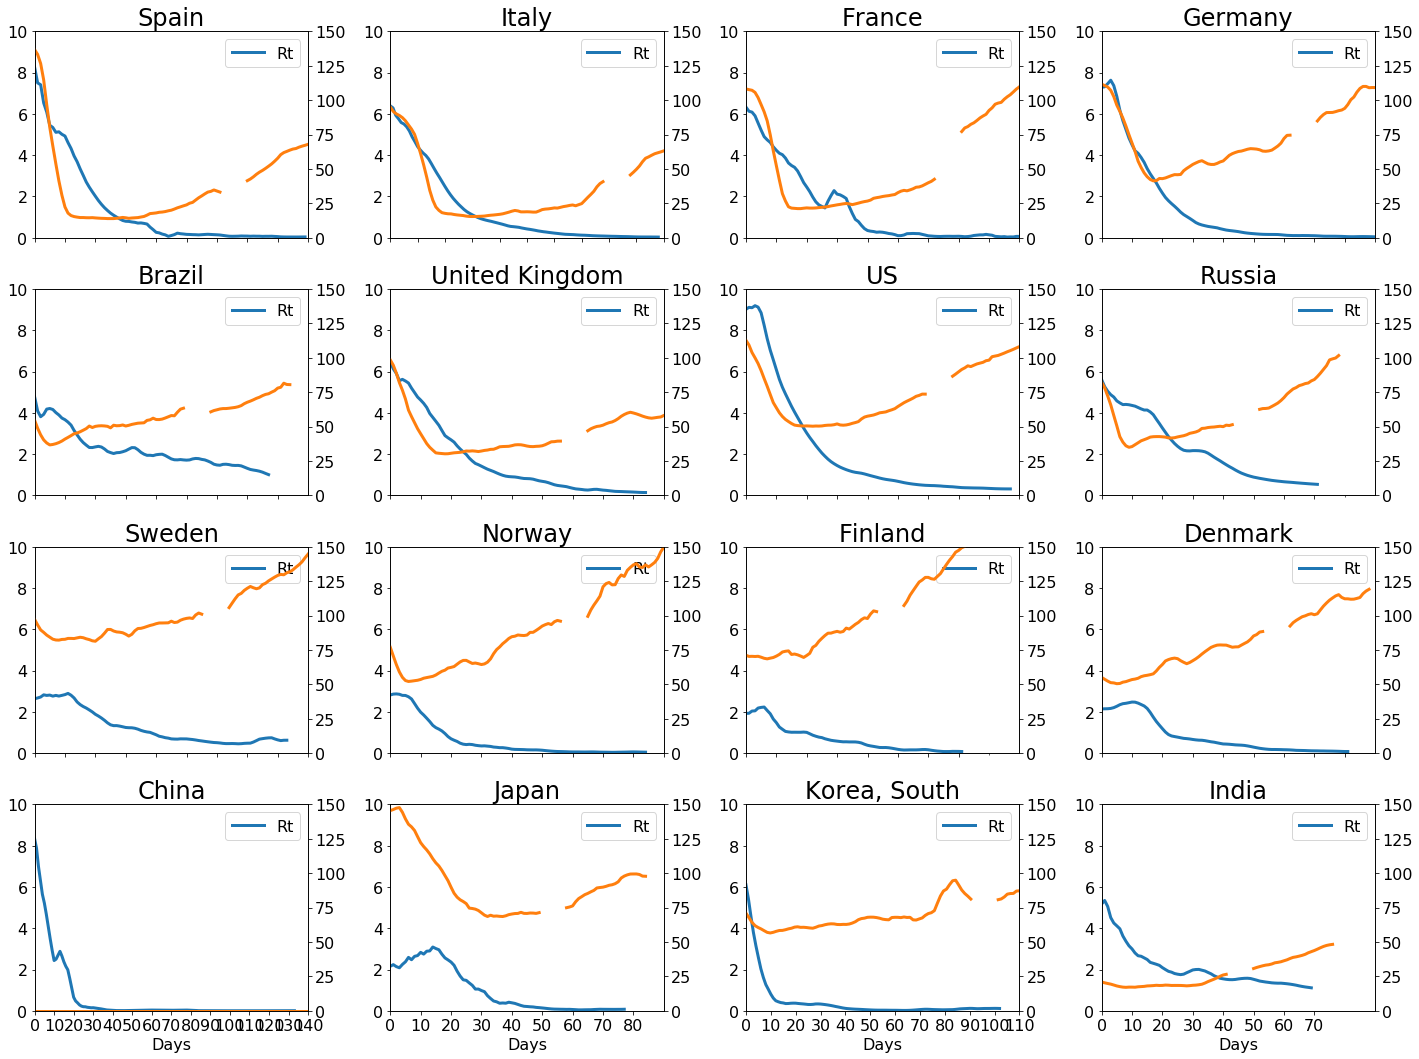

In [38]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        axe=df.plot('Days','Rt',ax=ax[i,j],linewidth=3,)
        axe.set_xlim(0, 90)
        axe.set_ylim(0, 10)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe,legend=False,xticks=df['Days'][::10], linewidth=3,)
        ax[i,j].right_ax.set_ylim(0, 150)
fig.tight_layout()
plt.show()

To see the relation more clearly, we compute the derivative $dR_t/dt$, and plot it together with Apple Mobility Index. Derivative is computed as simple first-order difference between daily values, and then averaged out using weekly average.

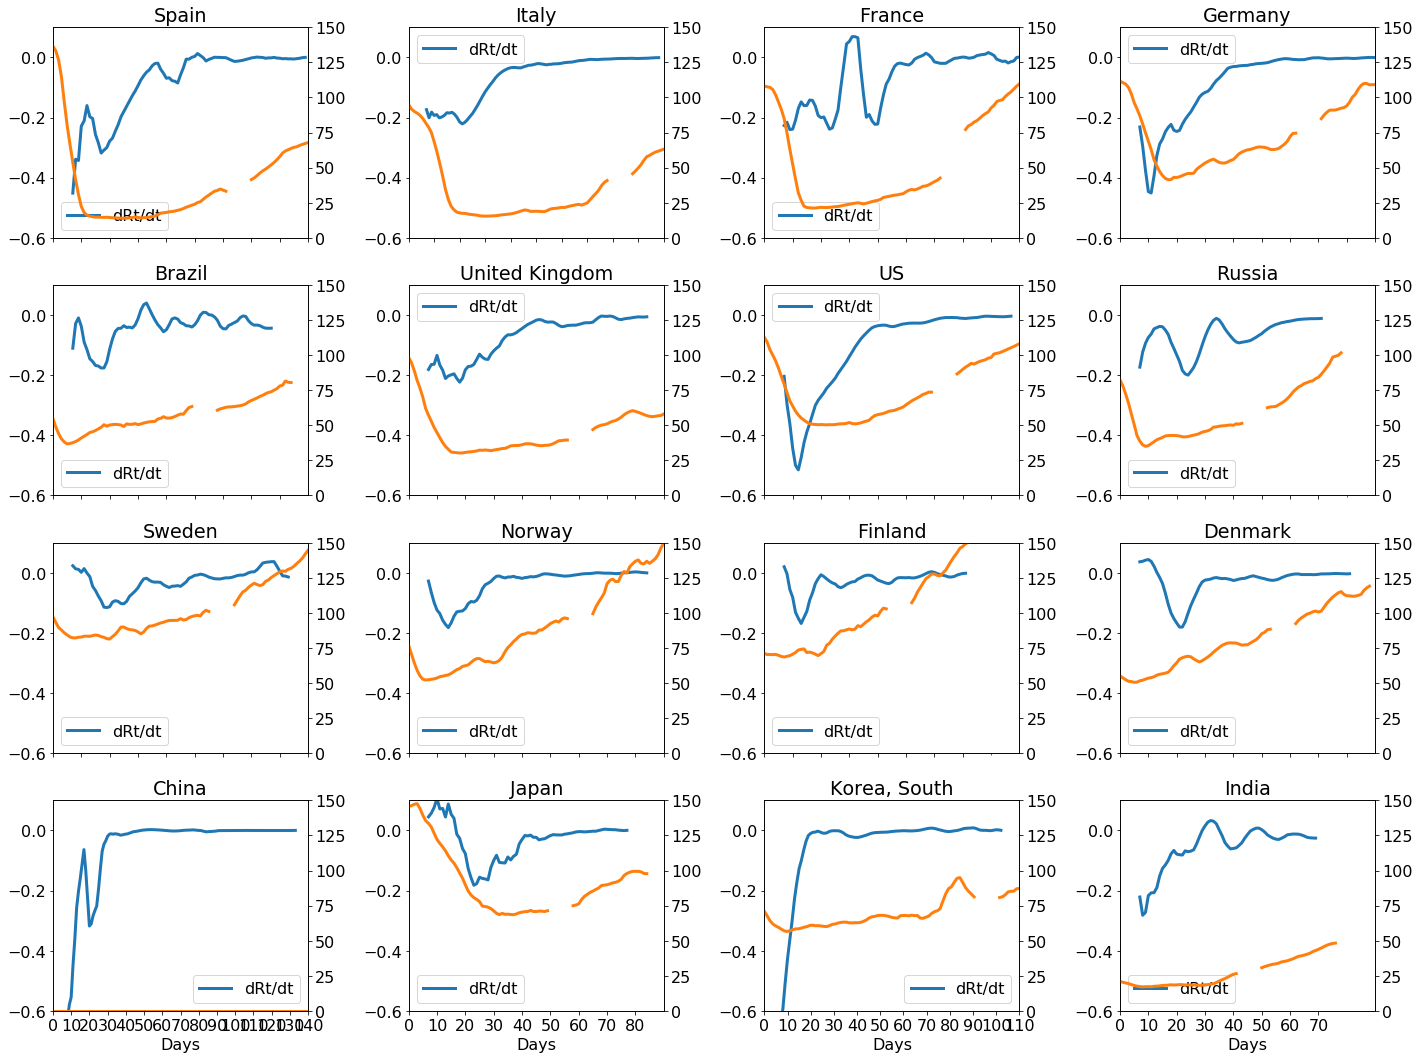

In [41]:
mx = max([len(x) for x in countries])
my = len(countries)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=16)
fig,ax = plt.subplots(my,mx,figsize=(20,15),sharex=False)
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        df["dRt/dt"] = df["Rt"].diff().rolling(window=7).mean()
        axe=df.plot('Days','dRt/dt',ax=ax[i,j],linewidth=3,)
        axe.set_xlim(0, 90)
        axe.set_ylim(-0.6, 0.1)
        axe.set_title(c,fontsize=24)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe,legend=False,xticks=df['Days'][::10], linewidth=3,)
        ax[i,j].right_ax.set_ylim(0, 150)
        ax[i,j].set_title(c)
fig.tight_layout()
plt.show()

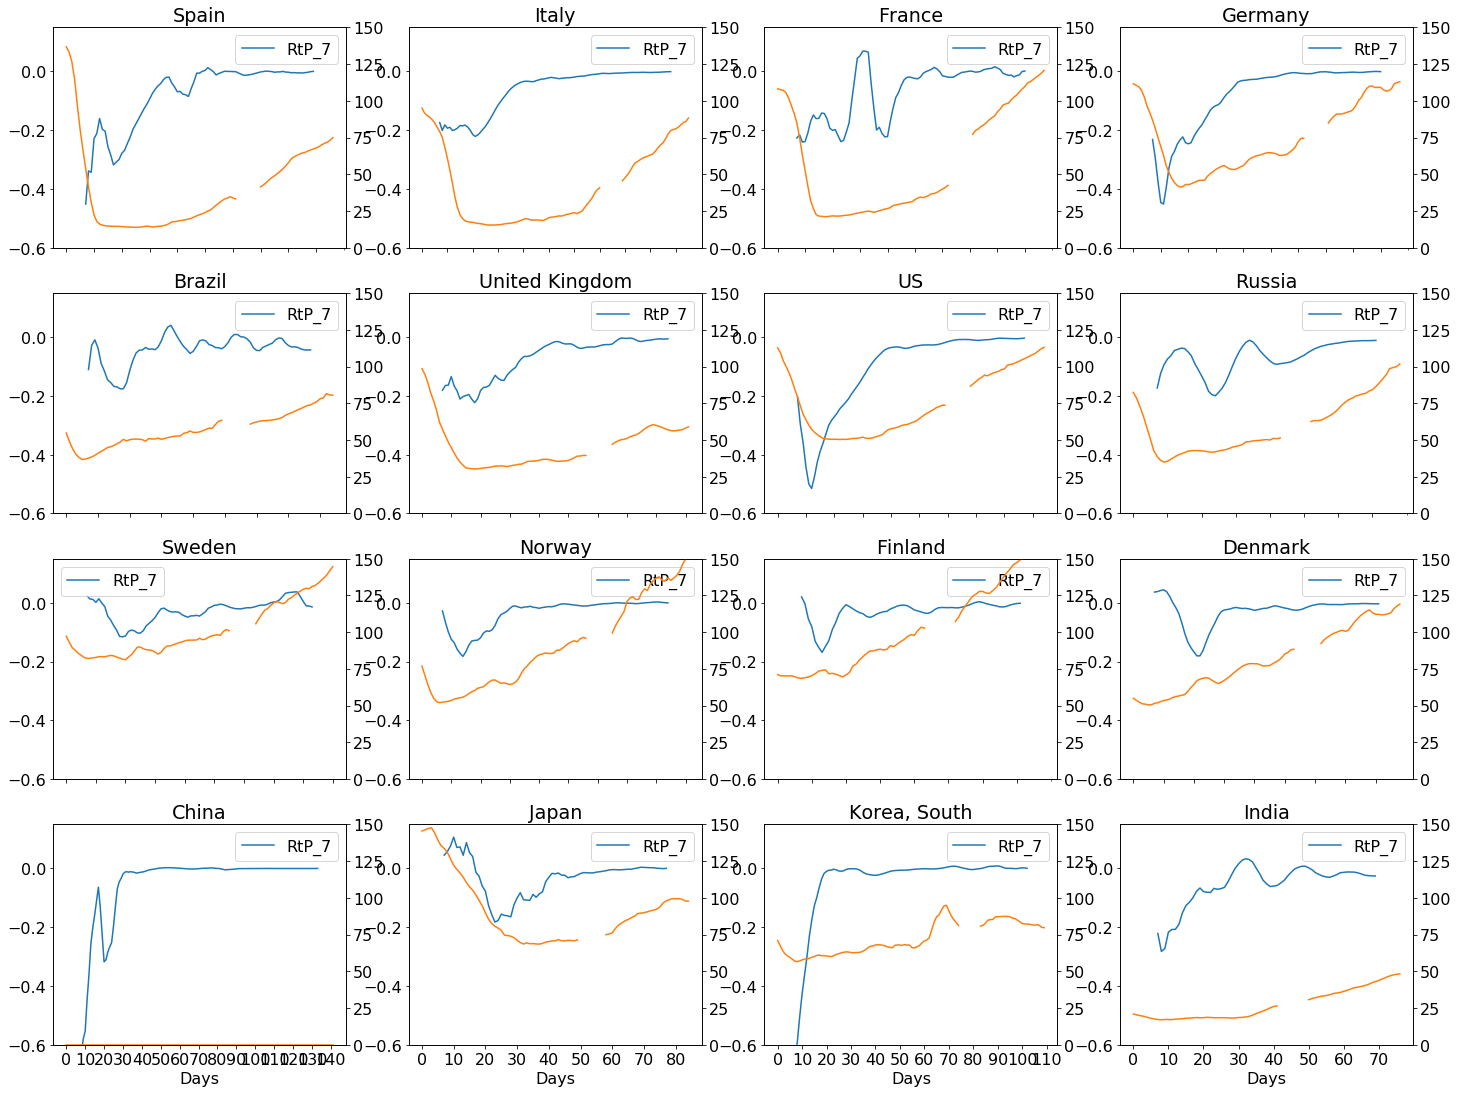

In [42]:
mx = max([len(x) for x in countries])
my = len(countries)
fig,ax = plt.subplots(my,mx,figsize=(20,15))
fig.tight_layout()
for i in range(my):
    for j in range(mx):
        c = countries[i][j]
        pop,df = country_datax[c]
        df["RtP"] = df["Rt"].diff()
        df["RtP_7"] = (df["RtP"]).rolling(window=7).mean()
        axe2=df.plot('Days','RtP_7',ax=ax[i,j])
        axe2.set_ylim(-0.6, 0.15)
        ax3 = df.plot('Days','AppleIndexAv',secondary_y=True,ax=axe2,legend=False,xticks=df['Days'][::10])
        ax[i,j].right_ax.set_ylim(0, 150)
        ax[i,j].set_title(c)

plt.show()